# Lab Session \# 06


---


by Josué Obregón <br>
BDA712-00 - Machine Learning Programming <br>
Department of Big Data Analytics - Kyung Hee University<br>

## Objective

The objective of this session is to try our logistic regression implementation using more complex data and to implement multiple class classification. 


# Getting the data

In [1]:
import gdown

In [4]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
urls = ['https://drive.google.com/uc?export=download&id=1MnUH3W1Jm8LVBqEJ1M0m5l9_Q8hJZqrz', # train-labels-idx1-ubyte.gz  https://drive.google.com/file/d/1MnUH3W1Jm8LVBqEJ1M0m5l9_Q8hJZqrz/view?usp=sharing       
        'https://drive.google.com/uc?export=download&id=1AZLWnMx1xe3vN1naEswKL19I02YrA7_J', # train-images-idx3-ubyte.gz  https://drive.google.com/file/d/1AZLWnMx1xe3vN1naEswKL19I02YrA7_J/view?usp=sharing       
        'https://drive.google.com/uc?export=download&id=1Hw8QHRxmI4w-ZAo5yzVjDB3UnUPAVv4u', # t10k-labels-idx1-ubyte.gz  https://drive.google.com/file/d/1Hw8QHRxmI4w-ZAo5yzVjDB3UnUPAVv4u/view?usp=sharing       
        'https://drive.google.com/uc?export=download&id=1EHdJfVQs1ZiRhCoEldMc9lTJ-5Nz5GaV', # t10k-images-idx3-ubyte.gz  https://drive.google.com/file/d/1EHdJfVQs1ZiRhCoEldMc9lTJ-5Nz5GaV/view?usp=sharing       
      ]
outputs = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
           't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']
for url,output in zip(urls,outputs):
  gdown.download(url, f'data/{output}', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1MnUH3W1Jm8LVBqEJ1M0m5l9_Q8hJZqrz
To: /content/data/train-labels-idx1-ubyte.gz
100%|██████████| 28.9k/28.9k [00:00<00:00, 54.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1AZLWnMx1xe3vN1naEswKL19I02YrA7_J
To: /content/data/train-images-idx3-ubyte.gz
100%|██████████| 9.91M/9.91M [00:00<00:00, 253MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Hw8QHRxmI4w-ZAo5yzVjDB3UnUPAVv4u
To: /content/data/t10k-labels-idx1-ubyte.gz
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.83MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1EHdJfVQs1ZiRhCoEldMc9lTJ-5Nz5GaV
To: /content/data/t10k-images-idx3-ubyte.gz
100%|██████████| 1.65M/1.65M [00:00<00:00, 218MB/s]


# Preliminaries

Let's import the data and prepare the variables that we will need for our laboratory

In [5]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array of bytes:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


def prepend_bias(X):
    # Insert a column of 1s in the position 0 of X.
    # (“axis=1” stands for: “insert a column, not a row”)
  return np.insert(X, 0, 1, axis=1) # insert(arr, obj, values, axis=None)

In [7]:
# 60000 images, each 785 elements (1 bias + 28 * 28 pixels)
X_train = prepend_bias(load_images('data/train-images-idx3-ubyte.gz'))

# 10000 images, each 785 elements, with the same structure as X_train
X_test = prepend_bias(load_images('data/t10k-images-idx3-ubyte.gz'))

# Exploring MNIST data

Let's explore the variables we just created

In [8]:
X_train.shape

(60000, 785)

In [9]:
X_test.shape

(10000, 785)

Let's observe the data we loaded

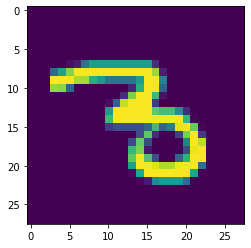

In [20]:
sample_id_train = 30
sample_train_image = X_train
image = np.reshape(sample_train_image[sample_id_train, 1:], (28, 28))
plt.imshow(image)

Let's load the labels now. Run the following code

In [ ]:
def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)

Let's use the function to load the labels for train and test data. Then let's explore the variables we just created.

In [ ]:
# 60K labels, each with value 1 if the digit is a five, and 0 otherwise
Y_train = load_labels('data/train-labels-idx1-ubyte.gz')

# 10000 labels, with the same encoding as Y_train
Y_test = load_labels('data/t10k-labels-idx1-ubyte.gz')

# Binary classification (using only one number)

The matrix returned by `load_labels()` contains labels from 0 to 9. But let's start simple and do binary classificatino first. You can choose any number you like. I will use number 5 but you can change that.

Let's first define a way to transform our multiclass classification problem into a binary classification problem.

Let's load all the functions we created in the last notebook

In [ ]:
def sigmoid(z):
  return 1/ (1+np.exp(-z))


def gradient(X, Y, beta):
  return np.matmul(X.T, (forward(X, beta) - Y)) / X.shape[0]


def forward(X, beta):
  weighted_sum = np.matmul(X, beta)
  return sigmoid(weighted_sum)

def predict(X, beta, return_proba=False):
  if return_proba:
    return forward(X,beta)
  else:
    return np.round(forward(X,beta))

def log_loss(X, Y, beta):
    y_hat = forward(X,beta)
    first_term = Y * np.log(y_hat)
    second_term = (1 - Y) * np.log(1 - y_hat)
    return -np.sum(first_term + second_term) / X.shape[0]

def train(X, Y, iterations, lr=0.001, precision=1e-6, print_step=1):
  beta = np.zeros((X.shape[1], 1))
  previous_loss = log_loss(X, Y, beta) 
  for i in range(iterations):
    if i % print_step ==0:
      print(f'Iteration {i} => Loss(MSE): {previous_loss:.10f}')
    beta -= gradient(X, Y, beta) * lr

    current_loss = log_loss(X, Y, beta)
    if (abs(current_loss - previous_loss) < precision):
      print(f'Early stop at iteration {i}')
      return beta
    previous_loss = current_loss

  return beta

def test(X,Y, beta):
  n = X.shape[0]
  tp = np.sum(predict(X, beta) == Y) # correct results
  accuracy = (tp / n) * 100 # success percent
  print(f'\nSuccess: {tp}/{n} ({accuracy:.2f})%')

## Summary first part

In this part of the session we got up close and personal with MNIST. 
* We got some code to import MNIST data and reshape it to X and Y matrices fit for our binary classification code. 
* In the end, we used our program to recognize one of the digits in MNIST, with very encouraging results.
* Along the way, you learned a few interesting facts about image recognition.
* You also learned something about testing ML systems, and how the results of a test can be tricky to interpret because of overfitting.
* In the next part, we’ll finally tackle the challenge that we set for ourselves on the second class: recognizing arbitrary digits. How will our code fare?



# Multiclass classification

We just learned in the slides that we have to build an array of ten probability estimations, one for each digit.

For that, we will first encode our $Y$ label using a very popular encoding technique, one-hot encoding.



> In digital circuits and machine learning, a one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0)



## One-hot encoding our target variable

We are going to encode our $Y$ labels into one big matrix with ten columns, where each column encodes a digit from 0 to 9.

Hint: remember the unique function of Numpy.

Try to do this by yourself

## Decoding the classifier output

Let’s review how `predict()` works. During the classification phase, the transformed weighted sum (linear combination + sigmoid given by `forward()` function) returns a soft prediction between 0 to 1 or a hard prediction, either 0 or 1.

```python
def predict(X, beta, return_proba=False):
  if return_proba:
    return forward(X,beta)
  else:
    return np.round(forward(X,beta))
```

```python
def forward(X, beta):
  weighted_sum = np.matmul(X, beta)
  return sigmoid(weighted_sum)
```

Now we have to return a vector of 10 probabilities, one for each digit, or a hard prediction, a number between 0 and 9.

How can we do that?

## Adding more weights (betas)

When we introduced one-hot encoding, we extended the matrix of labels from
one to ten columns. Now we need to do the same with the weights.

So far, our matrix of weights had one column, and one row per input variable.
We initialized it like this:
```python
beta = np.zeros((X.shape[1], 1))
```
Now we need ten columns of weights, one per class:

How can we do that?

In [ ]:
def train(X, Y, iterations, lr=0.001, precision=1e-6, print_step=1):
  #insert the new beta line below

  previous_loss = log_loss(X, Y, beta) 
  for i in range(iterations):
    if i % print_step ==0:
      print(f'Iteration {i} => Loss(Log-loss): {previous_loss:.10f}')
    beta -= gradient(X, Y, beta) * lr

    current_loss = log_loss(X, Y, beta)
    if (abs(current_loss - previous_loss) < precision):
      print(f'Early stop at iteration {i}')
      return beta
    previous_loss = current_loss

  return beta

## Summary second part

Let’s recap our first adventure in machine learning:

* At the beginning of the class we learned how Machine Learning Works and what machine learning and supervised learning are.
* Then we got our first concrete taste of supervised learning: we used linear regression to predict one variable from another.
* After that, we upgraded the learning program with a faster and more efficient algorithm: gradient descent.
* In the next step, we took advantage of gradient descent to implement multiple linear regression—like linear regression, only with multiple inputs.
* Our next step consisted in moving from multiple linear regression to classification.
* Then, we used our binary classifier to recognize a single digit in the MNIST dataset.
* Finally, we bumped up to multiclass classification, recognizing all MNIST characters with over 90% accuracy.

I hope you have learned a lot during the first 6 weeks of our course.
